In [1]:
# following stenum et al steps to ID gait events from vertical/frontal videos 

In [2]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
import os

# Gait event detection

## Frontal videos 

 Stenum et al: *Frontal Videos - We identified events of left and right gait cycles by local maxima and minima ofthe
**vertical distance** between the left and right ankle keypoints. Gait events on the left limb
were detected at positive peaks and gait events on the right limb were detected at nega-
tive peaks in trials where the participants walked away from the frontal plane camera;
and vice versa in trials where the participants walked toward the camera. In order to
unify the nomenclature ofgait events across motion capture data and sagittal and fron-
tal plane video data, we refer to the gait events ofthe frontal plane analysis as heel-
strikes.*

- limitation: gait events ID not truly "heel strikes" 

## to -do 
- For now, manually checking video length from visual annotation excel and using to convert frames to time. 
- - Need to write code to automatically make conversion. See self care selfies code
- this script: practice on video in one direction with known 10 steps
  - identify turns and walking toward or away from camera based on height for BW participant videos
  - OR annotate time visually?
- determine if filtering would improve accuracy?
    - can use stenum method to determine optimal filtering and movMean parameters

In [3]:
# mediapipe data frame, vertical = frontal 
# input_csv = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\hva_code\HomeVideoAnalysis\temp\main_branch_outputs\000_run\MM_HC_10steps_away_1_mediapipe_world.csv'
input_csv = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\hva_code\HomeVideoAnalysis\temp\main_branch_outputs\000_run\MM_HC_10steps_away_0_mediapipe_world.csv'
# video length in seconds- by visual annotation for now 
video_length_sec = 8

df_mp = pd.read_csv(input_csv, index_col = False)

#rename columns 
list(df_mp.columns)
df_mp = df_mp.rename(columns = {'Unnamed: 0':'label_num'})

# add time column 
# estimate hz from video length by eye 
total_frames = df_mp['frame'].max()
hz = total_frames/video_length_sec

#  tail should equal video length sec 
approx_time = df_mp['frame']/hz
print(approx_time.tail())

df_mp['approx_time_sec'] = approx_time



7948    8.0
7949    8.0
7950    8.0
7951    8.0
7952    8.0
Name: frame, dtype: float64


In [4]:
# check df for first set of landmarks 
df_mp.iloc[0:33, :]

,label_num,X,Y,Z,vis,pres,frame,label,approx_time_sec
0,0,0.026202,-0.660544,0.028324,0.999967,0.0,0,nose,0.0
1,1,0.016549,-0.691890,-0.000957,0.999957,0.0,0,left_eye_inner,0.0
2,2,0.016887,-0.692256,-0.000896,0.999956,0.0,0,left_eye,0.0
3,3,0.016614,-0.692721,-0.000839,0.999954,0.0,0,left_eye_outer,0.0
4,4,0.021321,-0.688173,-0.002061,0.999960,0.0,0,right_eye_inner,0.0
5,5,0.021500,-0.689041,-0.002809,0.999955,0.0,0,right_eye,0.0
6,6,0.021461,-0.690375,-0.001984,0.999952,0.0,0,right_eye_outer,0.0
7,7,-0.038516,-0.666676,-0.077720,0.999938,0.0,0,left_ear,0.0
8,8,0.054620,-0.663184,-0.092724,0.999948,0.0,0,right_ear,0.0
9,9,0.023454,-0.630338,0.005363,0.999970,0.0,0,mouth_left,0.0


## To do 
- Confirm Y orientation and if local mininum or maximum correspond to R or L gait events. As of 8/16/2024, code below uses positive values but plots show that this plots the stick figure "upside down". May need to use negative value of Y 
- check missing values and interpolation over missing. Stenum et al *We gap-filled keypoint trajectories using linear interpolation for gaps spanning to up 0.12 s.*
- Stenum et all supplementary figure 4 - make figure to see what filtering and moving mean combinations give most accurate results
    - moving mean script below: pd.Series(ank_y_diff).rolling(window=10, min_periods=1).mean(), change windows 

In [5]:
# create data frame with just ankles 
ank_df = df_mp.loc[(df_mp['label'] == 'left_ankle') | (df_mp['label'] == 'right_ankle')]

In [6]:
# Plot ankle markers for all frames (make sure reasonable values)
ank_l_df = ank_df.loc[(ank_df['label'] == 'left_ankle')]
ank_r_df = ank_df.loc[(ank_df['label'] == 'right_ankle')]

# set frame as index to subtract each frame 
ank_l_df.index = ank_l_df['frame']
ank_r_df.index = ank_r_df['frame']

# check df are same size 
print(len(ank_l_df))
print(len(ank_r_df))

241
241


Text(0.5, 1.0, 'Ankle Labels: MM_HC_10steps_away_0_mediapipe_world.csv')

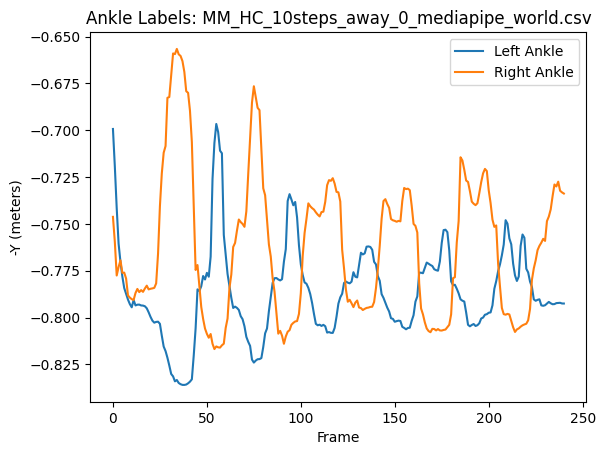

In [7]:
# plot Y vs frames 
plt.plot(ank_l_df['frame'], -ank_l_df['Y'], label = 'Left Ankle')
plt.plot(ank_r_df['frame'], -ank_r_df['Y'], label = 'Right Ankle')


plt.xlabel("Frame")
plt.ylabel("-Y (meters)")
plt.legend(loc = 'best')
plt.title('Ankle Labels: ' + os.path.basename(input_csv))

## To- do 
optimize rolling window - 15 works best here, stenum paper = 10 

In [8]:
# difference between Y values of left and right ankles 
        # min and max of this plot are gait events 

# vertical distance between l and r ankle; 2 = Y column 
# ank_y_diff_0 = ank_l_df.iloc[:,2] - ank_r_df.iloc[:,2]
ank_y_diff_0 = ank_l_df['Y'] - ank_r_df['Y']

# moving mean of Y difference - Stenum et al paper window = 10
ank_y_diff = pd.Series(ank_y_diff_0).rolling(window=15, min_periods=1).mean()

# find index of local minimum and maximum of distance between right and left ankle  
ank_y_diff_peaks_byFrame, _ = find_peaks(ank_y_diff)
ank_y_diff_valleys_byFrame, _ = find_peaks(-ank_y_diff)

# divide by Hz to get position of peaks in seconds, use for plots below 
ank_y_diff_peaks_bySecond = ank_y_diff_peaks_byFrame/hz
ank_y_diff_valleys_bySecond = ank_y_diff_valleys_byFrame/hz

# Output the local minima and maxima
print("Number of local maxima:", len(ank_y_diff_peaks_bySecond))
print("Number of local minima:", len(ank_y_diff_valleys_bySecond))

Number of local maxima: 5
Number of local minima: 5


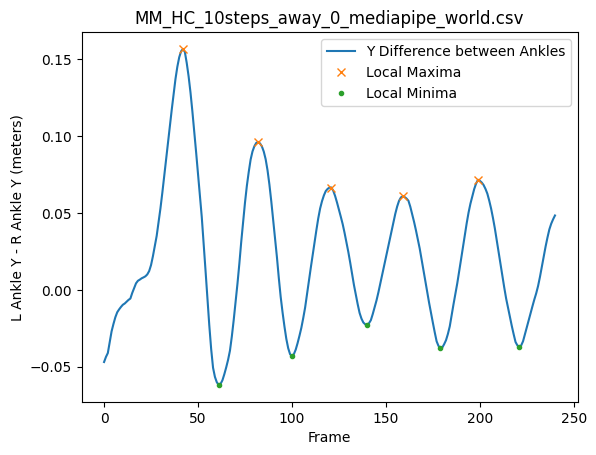

In [9]:
# plot y difference in ankles and add labels on local min and max 
plt.plot(ank_l_df['frame'], ank_y_diff, label='Y Difference between Ankles')
plt.plot(ank_y_diff_peaks_byFrame, ank_y_diff.iloc[ank_y_diff_peaks_byFrame], "x", label='Local Maxima')
plt.plot(ank_y_diff_valleys_byFrame, ank_y_diff.iloc[ank_y_diff_valleys_byFrame], ".", label='Local Minima')
plt.xlabel('Frame')
plt.ylabel("L Ankle Y - R Ankle Y (meters)")
plt.title(os.path.basename(input_csv))
plt.legend()
plt.show()

## ------------- Stride Time --------------------
PKMAS Definition Stride Time and Gait Cycle Time (listed under Gait Phase Category) use the same computation but both interchangeable measurements are available in PKMAS. The period of time from first contact of one foot, to the following first contact of the same foot (sec).

Stride Time CV% = coefficient of variation = (sd/mean) * 100
CV% per trial? direction toward or away?

- from deID all BW Zeno Stride time = mean = 1.2s, median = 1.14s

### Things to confirm in calculations 
- Time reported separately for each leg? Or are R and L combined for CV% calculation?
- Is one CV% reported for each trial (up and back x times)? Or CV% reported for each walk toward and away from camera?

In [10]:
# Stride time 

# Time between local max - R or L gait event (TBD)
stride_times_peaks = pd.Series(ank_y_diff_peaks_bySecond).diff()
stride_time_peaks_mean = np.mean(stride_times_peaks)
stride_time_peaks_std = np.std(stride_times_peaks)
stride_time_peaks_cv = (stride_time_peaks_std/stride_time_peaks_mean) * 100
print("Leg 1 (peaks) Mean Stride Time = " + str(round(stride_time_peaks_mean, 2)) + " seconds")
print("Leg 1 (peaks) Stride Time Standard Deviation = " + str(round(stride_time_peaks_std, 2)) + " seconds")
print("Leg 1 (peaks) Stride Time CV% = " + str(round(stride_time_peaks_cv, 2)) + "%")

# Time between local min - R or L  gait event (TBD) 
stride_times_valleys = pd.Series(ank_y_diff_valleys_bySecond).diff()
stride_time_valleys_mean = np.mean(stride_times_valleys)
stride_time_valleys_std = np.std(stride_times_valleys)
stride_time_valleys_cv = (stride_time_valleys_std/stride_time_valleys_mean) * 100
print("Leg 2 (valleys) Mean Stride Time = " + str(round(stride_time_valleys_mean, 2)) + " seconds")
print("Leg 2 (valleys) Stride Time Standard Deviation = " + str(round(stride_time_valleys_std, 2)) + " seconds")
print("Leg 2 (valleys) Stride Time CV% = " + str(round(stride_time_valleys_cv, 2)) + "%")

Leg 1 (peaks) Mean Stride Time = 1.31 seconds
Leg 1 (peaks) Stride Time Standard Deviation = 0.03 seconds
Leg 1 (peaks) Stride Time CV% = 2.11%
Leg 2 (valleys) Mean Stride Time = 1.33 seconds
Leg 2 (valleys) Stride Time Standard Deviation = 0.04 seconds
Leg 2 (valleys) Stride Time CV% = 3.06%


## ------------- Cadence -------------------------------------
PKMAS - The number of footfalls minus one divided by the ambulation time, converted to minutes (steps/min). Cadence is shown on the “Mean” row of the Gait Table

In [11]:
# cadence 
total_steps = len(ank_y_diff_peaks_bySecond) + len(ank_y_diff_valleys_bySecond) # peaks + valleys
cadence = (total_steps/video_length_sec) * 60

print("Total steps = " + str(total_steps))
print("Video Length (s) = " + str(video_length_sec)) # will need to update based on segments of video 
print("Cadence = " + str(cadence) + " steps/minute")

Total steps = 10
Video Length (s) = 8
Cadence = 75.0 steps/minute


## ------------- Stride width -----------------------
PKMAS - Stride Width is the perpendicular distance between the line connecting the two ipsilateral foot heel contacts (stride) with the contralateral heel contact between those events (cm).
- don't think we can calculate in same way without z distance in vertical videos.
- from deID Brainwalk dataset: Zeno stride width - mean 9.3 cm, median 9.1 cm

Try difference in x value of heels when y difference between heels = 0 
- filter outliers in first few frames?
- Does "width" get smaller as person moves away from the camera? 
- Other ideas?

Text(0.5, 1.0, 'Heel Labels: MM_HC_10steps_away_0_mediapipe_world.csv')

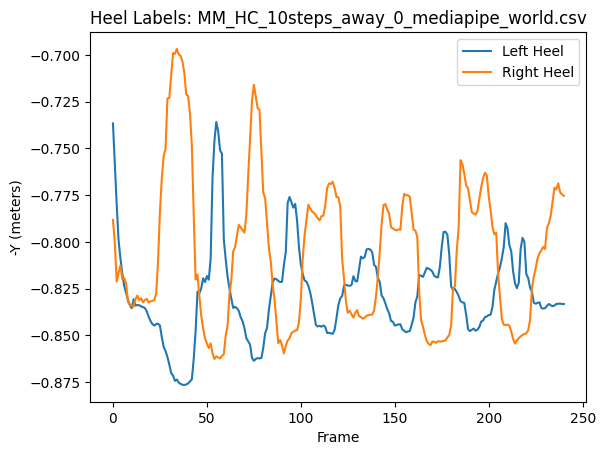

In [12]:
# stride Width calculation
heel_r_df = df_mp.loc[(df_mp['label'] == 'right_heel')]
heel_l_df = df_mp.loc[(df_mp['label'] == 'left_heel')]

# set index to frame 
heel_r_df.index = heel_r_df['frame']
heel_l_df.index = heel_l_df['frame']

# plot Y vs frames 
plt.plot(heel_l_df['frame'], -heel_l_df['Y'], label = 'Left Heel')
plt.plot(heel_r_df['frame'], -heel_r_df['Y'], label = 'Right Heel')
plt.xlabel("Frame")
plt.ylabel("-Y (meters)")
plt.legend(loc = 'best')
plt.title('Heel Labels: ' + os.path.basename(input_csv))

### To - do 
Check across other plots - will frame zero be included every time? If so, remove first cross_zero_frame value..

In [13]:
# vertical difference between l and R ankle 
heel_y_diff_0 = heel_l_df.iloc[:,2] - heel_r_df.iloc[:,2]
heel_y_diff = pd.Series(heel_y_diff_0).rolling(window=15, min_periods=1).mean()

# frames when y diff crosses zero 
# Determine the sign of each value (+1 for positive, -1 for negative, 0 for zero)
signs = np.sign(heel_y_diff)
# find indices where sign changes (crosses zero) 
cross_zero_frame = crossing_indices = signs.diff().ne(0).index[signs.diff().ne(0) & (signs != 0)]

# subset r + l heel df to only those frames 
heel_r_df_zero_cross = heel_r_df.loc[cross_zero_frame]
heel_l_df_zero_cross = heel_l_df.loc[cross_zero_frame]

# find horizontal difference between heels at those frames 
x_diff = abs(heel_l_df_zero_cross['X'] - heel_r_df_zero_cross['X'])
x_diff_mean = np.mean(x_diff)
x_diff_std = np.std(x_diff)
x_diff_cv = (x_diff_std/x_diff_mean) * 100

print("Mean Stride Width = " + str(round(x_diff_mean, 2)) + " m")
print("Stride Width Standard Deviation = " + str(round(x_diff_std, 2)) + " m")
print("Stride Width CV% = " + str(round(x_diff_cv, 2)) + "%")

Mean Stride Width = 0.12 m
Stride Width Standard Deviation = 0.03 m
Stride Width CV% = 24.89%


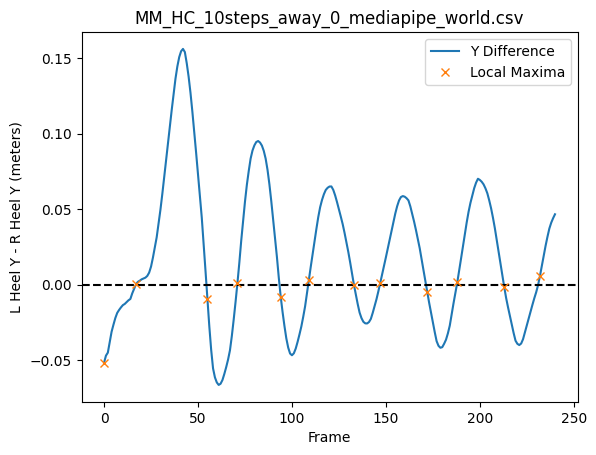

In [14]:
# plot y distance between heels, confirm zero crossing values are correct 
plt.plot(heel_l_df['frame'], heel_y_diff, label = 'Y Difference')
plt.axhline(y=0, color='black', linestyle='--')
plt.plot(cross_zero_frame, heel_y_diff.iloc[cross_zero_frame], "x", label='Local Maxima')
plt.xlabel("Frame")
plt.ylabel("L Heel Y - R Heel Y (meters)")
plt.title(os.path.basename(input_csv))
plt.legend()
plt.show()

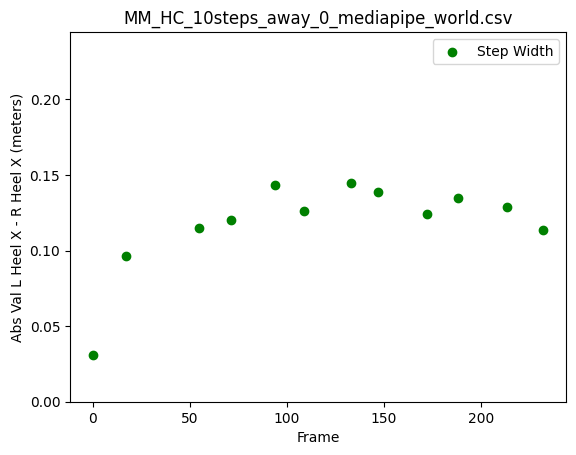

In [15]:
# visualize to show changes in x diff makes sense 
# Does width decrease when as person is further from camera? 

plt.scatter(cross_zero_frame, x_diff, color = 'green', label = 'Step Width')
plt.ylabel('Abs Val L Heel X - R Heel X (meters)')
plt.xlabel('Frame')
plt.ylim([0, max(x_diff) + .1])
plt.title(os.path.basename(input_csv))
plt.legend()

### Val: Area under the curve of metrics above 
- compare R and L area under the curve for Y ankle height height
- Max Y height R vs L
- variation in stride width 

### Val: Stride time assymetry: R vs L (see zeno measures)

# ------------- single and double support -------------
Use some combo of foot and heel markers to estimate when both feet are on the ground? 

## Total double support % (Mean) 

## Total Double Support % - Ratio - L/R

## Single Support % - Ratio - L/R

## Single Support % - Mean 

# -------------  Turns -------------------------
- na for this video, no turns in my 10 step video
- see segment code for ID turns and toward or away 

## Steps Per turn 

## Turn time 

## Time between turns (how long to walk and turn around, measure of fatigue)
- change in time between turns (was last walk a lot slower than first walk?) 

# ------------ Angles and landmark position --------------------

## hip position relative to ankles (stability?) - angle between shoulder, hip, and foot/knee marker?
- mean
- median
- variability
- change per walk

## hip knee ankle angle 

## variability in trunk x position 
- during walk, how straight of a line are they walking in?
- during turn, how wide are their turns? 

# smoothness of pace 
- not sure how, but does y height in pixels (as proxy for change in distance) decrease at a consistent rate as they are walking away? Increase at consistent rate as they are walking towards? Or are they starting and stopping...?